#**Importing the necessary libraries**

In [1]:
# importing the necessary libraries
import json, requests, sys
import pandas as pd
import re
from bs4 import BeautifulSoup
from langchain.text_splitter import RecursiveCharacterTextSplitter
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding # for tokenizing and padding
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score # for returning the accuracy score, f1, precision and recall
from transformers import ModernBertForSequenceClassification # automatically chooses the right transformer-model for classification
from transformers import TrainingArguments # for defining the training arguments
from transformers import Trainer # for initializing the trainer
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from transformers import pipeline
from transformers import AutoModelForSequenceClassification

#**Loading the file**

In [ ]:
# loading the json-file of the presidential speeches
endpoint = "https://api.millercenter.org/speeches"
out_file = "speeches.json"

r = requests.post(url=endpoint)
data = r.json()
items = data['Items']

while 'LastEvaluatedKey' in data:
    parameters = {"LastEvaluatedKey": data['LastEvaluatedKey']['doc_name']}
    r = requests.post(url = endpoint, params = parameters)
    data = r.json()
    items += data['Items']
    print(f'{len(items)} speeches')

with open(out_file, "w") as out:
    out.write(json.dumps(items))
    print(f'wrote results to file: {out_file}')

In [2]:
df_raw = pd.read_json("speeches_all.json", orient="record")
print(df_raw)

                                               doc_name  \
0     january-22-1807-special-message-congress-burr-...   
1     may-25-1813-message-special-congressional-sess...   
2     april-2-1917-address-congress-requesting-decla...   
3               april-10-1975-address-us-foreign-policy   
4     july-6-1848-message-regarding-treaty-guadalupe...   
...                                                 ...   
1058                     april-6-1917-proclamation-1364   
1059            july-13-1965-press-conference-east-room   
1060              december-2-1872-fourth-annual-message   
1061  july-19-1867-message-regarding-reconstruction-...   
1062  april-9-1844-message-regarding-disturbances-rh...   

                           date  \
0                    1807-01-22   
1                    1813-05-25   
2                    1917-04-02   
3                    1975-04-10   
4                    1848-07-06   
...                         ...   
1058                 1917-04-06   
1059       

#**Cleaning the Data**

In [3]:
# dataframe of Donald Trumps Speeches
mask_trump = df_raw["president"] == "Donald Trump"
df_trump = df_raw[mask_trump]
df_trump = df_trump.reset_index(drop=True)
print(df_trump)

                                             doc_name  \
0   october-26-2020-swearing-ceremony-honorable-am...   
1                june-21-2025-address-american-people   
2                    january-19-2021-farewell-address   
3                 february-4-2020-state-union-address   
4   september-25-2018-address-73rd-session-united-...   
5     january-6-2021-speech-urging-supporters-go-home   
6              july-24-2017-speech-boy-scout-jamboree   
7   september-19-2017-address-united-nations-gener...   
8                 january-30-2018-state-union-address   
9          june-13-2020-address-west-point-graduation   
10  february-15-2018-statement-school-shooting-par...   
11  december-18-2017-remarks-national-security-str...   
12                 september-25-2019-press-conference   
13        september-7-2020-labor-day-press-conference   
14        march-4-2025-address-joint-session-congress   
15    february-28-2017-address-joint-session-congress   
16  february-15-2019-speech-dec

In [4]:
# dataframe of Joe Bidens speeches
mask_biden = df_raw["president"] == "Joe Biden"
df_biden = df_raw[mask_biden]
df_biden = df_biden.reset_index(drop=True)
print(df_biden)

                                             doc_name  \
0   september-9-2021-remarks-fighting-covid-19-pan...   
1                   january-20-2021-inaugural-address   
2   september-24-2024-address-79th-united-nations-...   
3         march-31-2021-announcing-american-jobs-plan   
4   february-21-2023-remarks-one-year-anniversary-...   
5   november-15-2021-signing-infrastructure-invest...   
6   september-21-2022-speech-77th-session-united-n...   
7   february-24-2022-remarks-russian-invasion-ukraine   
8        march-26-2022-remarks-support-people-ukraine   
9   july-8-2021-speech-drawdown-us-forces-afghanistan   
10  june-1-2021-remarks-commemorating-100th-annive...   
11  january-6-2022-remarks-anniversary-january-6th...   
12  august-26-2021-statement-terror-attacks-afghan...   
13       august-16-2021-remarks-situation-afghanistan   
14  january-5-2024-speech-third-anniversary-januar...   
15                   march-1-2022-state-union-address   
16       april-28-2021-address-

In [5]:
# dataframe of all the other presidents
mask_rest_one = df_raw["president"] != "Donald Trump"
mask_rest_two = df_raw["president"] != "Joe Biden"
df_rest = df_raw[mask_rest_one & mask_rest_two]
df_rest = df_rest.reset_index(drop=True)
print(df_rest)

                                              doc_name  \
0    january-22-1807-special-message-congress-burr-...   
1    may-25-1813-message-special-congressional-sess...   
2    april-2-1917-address-congress-requesting-decla...   
3              april-10-1975-address-us-foreign-policy   
4    july-6-1848-message-regarding-treaty-guadalupe...   
..                                                 ...   
983                     april-6-1917-proclamation-1364   
984            july-13-1965-press-conference-east-room   
985              december-2-1872-fourth-annual-message   
986  july-19-1867-message-regarding-reconstruction-...   
987  april-9-1844-message-regarding-disturbances-rh...   

                          date  \
0                   1807-01-22   
1                   1813-05-25   
2                   1917-04-02   
3                   1975-04-10   
4                   1848-07-06   
..                         ...   
983                 1917-04-06   
984                 1965-07-13 

In [6]:
# checking the period of the transcribed speeches
my_list = []
for element in df_raw["date"]:
  my_list.append(element[:4])

print(min(my_list))
print(max(my_list))

1789
2025


In [7]:
data_trump_extracted = df_trump[["transcript", "president"]]
data_label_trump = data_trump_extracted.assign(label=0)
data_trump = data_label_trump[["transcript", "label"]]
data_trump = data_trump.rename(columns={"transcript": "text"})
print(data_trump)

                                                 text  label
0    \r\n\r\nTHE PRESIDENT:  Thank you very much. ...      0
1   Thank you very much.\n A short time ago, the U...      0
2   My fellow Americans: Four years ago, we launch...      0
3   Thank you very much. Thank you. Thank you very...      0
4   THE PRESIDENT: Madam President, Mr. Secretary-...      0
5   I know your pain. I know your hurt.\r\n\r\nWe ...      0
6   TRUMP: Thank you, everybody. Thank you very mu...      0
7   PRESIDENT TRUMP: Mr. Secretary General, Mr. Pr...      0
8   Mr. Speaker, Mr. Vice President, Members of Co...      0
9   Thank you, General, and hello cadets. On behal...      0
10  THE PRESIDENT: My fellow Americans, today I sp...      0
11  THE PRESIDENT: Thank you very much. Thank you....      0
12  PRESIDENT TRUMP:  Thank you very much.  Thank ...      0
13  THE PRESIDENT: Thank you very much. Thank you....      0
14  THE PRESIDENT: Speaker Johnson, Vice President...      0
15  Mr. Speaker, Mr. Vic

In [8]:
data_biden_extracted = df_biden[["transcript", "president"]]
data_label_biden = data_biden_extracted.assign(label=1)
data_biden = data_label_biden[["transcript", "label"]]
data_biden = data_biden.rename(columns={"transcript": "text"})
print(data_biden)

                                                 text  label
0   THE PRESIDENT: Good evening, my fellow America...      1
1   Chief Justice Roberts, Vice President Harris, ...      1
2   <p class="p1"><span class="s1">THE PRESIDENT: ...      1
3   THE PRESIDENT: Thank you. (Applause.) (Inaudib...      1
4   THE PRESIDENT:  Hello, Poland! One of our grea...      1
5   THE PRESIDENT: Thank you, thank you, thank you...      1
6   Thank you. \r\n\r\nMr. President, Mr. Secretar...      1
7   THE PRESIDENT: Sorry to keep you waiting. Good...      1
8   THE PRESIDENT: Thank you, thank you, thank you...      1
9   THE PRESIDENT: Good afternoon. Earlier today, ...      1
10  THE PRESIDENT: Well, thank you. Please, if you...      1
11  VICE PRESIDENT: Fellow Americans, good morning...      1
12  THE PRESIDENT: Been a tough day. This evening ...      1
13  THE PRESIDENT: Good afternoon. I want to speak...      1
14  THE PRESIDENT: Thank you, thank you, thank you...      1
15  SPEAKER OF THE HOUSE

In [9]:
data_rest_extracted = df_rest[["transcript", "president"]]
data_label_rest = data_rest_extracted.assign(label=2)
data_rest = data_label_rest[["transcript", "label"]]
data_rest = data_rest.rename(columns={"transcript": "text"})
print(data_rest)

                                                  text  label
0    TO THE SENATE AND HOUSE OF REPRESENTATIVES OF ...      2
1    Fellow-Citizens of the Senate and of the House...      2
2    I have called the Congress into extraordinary ...      2
3    Mr. Speaker, Mr. President, distinguished gues...      2
4    To the House of Representatives of the United ...      2
..                                                 ...    ...
983  Whereas the Congress of the United States in t...      2
984  THE PRESIDENT. Good afternoon, ladies and gent...      2
985  To the Senate and House of Representatives: In...      2
986  To the House of Representatives of the United ...      2
987  To the House of Representatives:\n In complian...      2

[988 rows x 2 columns]


In [10]:
# function to clean the text
# removing html-tags, removing comments in brackets, substituting line breaks with spaces,
# removing the beginning with "the president" etc., double spaces to single space,
# removing whitespaces,
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"\([^)]*\)", "", text)
    text = text.replace("\n", " ")
    text = re.sub(
        r"^\s*(mr\. president|the president|president(?:\s+biden)?)[:,]?\s*",
        "",
        text,
        flags=re.IGNORECASE
    )
    text = re.sub(r"\s+", " ", text)
    text = text.strip()
    return text

In [11]:
# cleaning the biden texts
data_biden["text"] = data_biden["text"].apply(clean_text)

print(data_biden)

                                                 text  label
0   Good evening, my fellow Americans. I want to t...      1
1   Chief Justice Roberts, Vice President Harris, ...      1
2   My fellow leaders, today is the fourth time I’...      1
3   Thank you. Mike asked me — and I said to Bobby...      1
4   Hello, Poland! One of our great allies. Presid...      1
5   Thank you, thank you, thank you. Thank you. AU...      1
6   Thank you. Mr. President, Mr. Secretary-Genera...      1
7   Sorry to keep you waiting. Good afternoon. The...      1
8   Thank you, thank you, thank you. Please, if yo...      1
9   Good afternoon. Earlier today, I was briefed b...      1
10  Well, thank you. Please, if you have a seat, s...      1
11  VICE PRESIDENT: Fellow Americans, good morning...      1
12  Been a tough day. This evening in Kabul, as yo...      1
13  Good afternoon. I want to speak today to the u...      1
14  Thank you, thank you, thank you. Thank you. AU...      1
15  SPEAKER OF THE HOUSE

In [12]:
# cleaning the trump texts
data_trump["text"] = data_trump["text"].apply(clean_text)

print(data_trump)

                                                 text  label
0   Thank you very much. Appreciate it. Thank you ...      0
1   Thank you very much. A short time ago, the U.S...      0
2   My fellow Americans: Four years ago, we launch...      0
3   Thank you very much. Thank you. Thank you very...      0
4   Madam President, Mr. Secretary-General, world ...      0
5   I know your pain. I know your hurt. We had an ...      0
6   TRUMP: Thank you, everybody. Thank you very mu...      0
7   TRUMP: Mr. Secretary General, Mr. President, w...      0
8   Mr. Speaker, Mr. Vice President, Members of Co...      0
9   Thank you, General, and hello cadets. On behal...      0
10  My fellow Americans, today I speak to a nation...      0
11  Thank you very much. Thank you. Please. I want...      0
12  TRUMP: Thank you very much. Thank you. Well, t...      0
13  Thank you very much. Thank you. Happy Labor Da...      0
14  Speaker Johnson, Vice President Vance, the fir...      0
15  Mr. Speaker, Mr. Vic

In [13]:
# cleaning the rest texts
data_rest["text"] = data_rest["text"].apply(clean_text)

print(data_rest)

                                                  text  label
0    TO THE SENATE AND HOUSE OF REPRESENTATIVES OF ...      2
1    Fellow-Citizens of the Senate and of the House...      2
2    I have called the Congress into extraordinary ...      2
3    Mr. Speaker, Mr. President, distinguished gues...      2
4    To the House of Representatives of the United ...      2
..                                                 ...    ...
983  Whereas the Congress of the United States in t...      2
984  . Good afternoon, ladies and gentlemen. Secret...      2
985  To the Senate and House of Representatives: In...      2
986  To the House of Representatives of the United ...      2
987  To the House of Representatives: In compliance...      2

[988 rows x 2 columns]


In [14]:
# checking the length of the dataframes
print(f"Biden: {len(data_biden)}")
print(f"Trump: {len(data_trump)}")
print(f"Rest: {len(data_rest)}")

Biden: 29
Trump: 46
Rest: 988


In [15]:
# brining the rest-data in the volume of the trump-data

data_rest = data_rest.sample(n=len(data_trump), random_state=42, ignore_index=True)
print(len(data_rest))

46


In [16]:
# checking if there are any empty cells in the biden text-column

leer_mask_biden = data_biden["text"].isna() | data_biden["text"].str.strip().eq("")

print(leer_mask_biden.any())

False


In [17]:
# checking if there are any empty cells in the trump text-column

leer_mask_trump = data_trump["text"].isna() | data_trump["text"].str.strip().eq("")

print(leer_mask_trump.any())

False


In [18]:
# checking if there are any empty cells in the rest text-column

leer_mask_rest = data_rest["text"].isna() | data_rest["text"].str.strip().eq("")

print(leer_mask_rest.any())

False


#**Chunking the Data with overlap**

In [19]:
# Creating a RecursiveCharacterTextSplitter for sentence-based chunking
sentence_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,     # Number of characters per chunk
    chunk_overlap=50,   # Overlap to maintain context
    separators=["\n\n", "\n", ".", " "]  # Prioritize splitting on paragraph, newline, and sentence boundaries
)

**Trump:**

In [20]:
# making list with all the speeches for chunking it

list_trump = []

for element in data_trump["text"]:
    list_trump.append(element)

In [21]:
list_trump_chunks = []
# Split the text into sentence-based chunks
for element in list_trump:
  sentence_chunks_trump = sentence_splitter.split_text(element)
  list_trump_chunks.append(sentence_chunks_trump)

print(list_trump_chunks)

[['Thank you very much. Appreciate it. Thank you very much. Distinguished guests and my fellow citizens, this is a momentous day for America, for the United States Constitution, and for the fair and impartial rule of law. The Constitution is the ultimate defense of American liberty. The faithful application of the law is the cornerstone of our Republic', '. That is why, as President, I have no more solemn obligation and no greater honor than to appoint Supreme Court justices. On this October evening — and it is so beautiful — the First Lady and I welcome you to the White House to bear witness to history. In a few moments, we will proudly swear in the newest member of the United States Supreme Court: Justice Amy Coney Barrett', '. She is one of our nation’s most brilliant legal scholars, and she will make an outstanding justice on the highest court in our land. Justice Barrett’s oath will be administered by the Court’s longest-serving member currently on the bench — a man whose allegian

In [22]:
# appending the chunks with corresponding labels to the list

rows_trump = []

for chunks in list_trump_chunks:
  for chunk in chunks:
    rows_trump.append({"label": 0, "text": chunk})

In [23]:
# converting the list into the df with the necessary format for further processing

df_trump_chunks = pd.DataFrame(rows_trump, columns = ["label", "text"])
print(df_trump_chunks)

      label                                               text
0         0  Thank you very much. Appreciate it. Thank you ...
1         0  . That is why, as President, I have no more so...
2         0  . She is one of our nation’s most brilliant le...
3         0  . Our country owes a debt of thanks to Senate ...
4         0  . And I hope I didn’t leave anybody out. And a...
...     ...                                                ...
3886      0  . This means that 300,000 immigrants whose pro...
3887      0  . That is our plan: border security, DACA, TPS...
3888      0  . This plan solves the immediate crisis—and it...
3889      0  . Once the government is open and we have made...
3890      0  . Whatever we do, I can promise you this: I wi...

[3891 rows x 2 columns]


**Biden:**

In [24]:
# making list with all the speeches for chunking it

list_biden = []

for element in data_biden["text"]:
    list_biden.append(element)

In [25]:
list_biden_chunks = []
# Split the text into sentence-based chunks
for element in list_biden:
  sentence_chunks_biden = sentence_splitter.split_text(element)
  list_biden_chunks.append(sentence_chunks_biden)

print(list_biden_chunks)

[['Good evening, my fellow Americans. I want to talk to you about where we are in the battle against COVID-19, the progress we’ve made, and the work we have left to do. And it starts with understanding this: Even as the Delta variant 19 [sic] has—COVID-19—has been hitting this country hard, we have the tools to combat the virus, if we can come together as a country and use those tools', '. If we raise our vaccination rate, protect ourselves and others with masking and expanded testing, and identify people who are infected, we can and we will turn the tide on COVID-19. It will take a lot of hard work, and it’s going to take some time. Many of us are frustrated with the nearly 80 million Americans who are still not vaccinated, even though the vaccine is safe, effective, and free', '. You might be confused about what is true and what is false about COVID-19. So before I outline the new steps to fight COVID-19 that I’m going to be announcing tonight, let me give you some clear information 

In [26]:
# appending the chunks with corresponding labels to the list

rows_biden = []

for chunks in list_biden_chunks:
  for chunk in chunks:
    rows_biden.append({"label": 1, "text": chunk})

In [27]:
# converting the list into the df with the necessary format for further processing

df_biden_chunks = pd.DataFrame(rows_biden, columns = ["label", "text"])
print(df_biden_chunks)

      label                                               text
0         1  Good evening, my fellow Americans. I want to t...
1         1  . If we raise our vaccination rate, protect ou...
2         1  . You might be confused about what is true and...
3         1  . Today, over 175 million Americans have that ...
4         1  . And in the three months before I took office...
...     ...                                                ...
1995      1  . Too many innocent people have been killed, i...
1996      1  . I know this is a subject on which people in ...
1997      1  . Through it all, though, the United States ha...
1998      1  . But I need your help. Everyone who wants pea...
1999      1  . It’s time for this war to end and for the da...

[2000 rows x 2 columns]


**Rest:**

In [28]:
# making list with all the speeches for chunking it

list_rest = []

for element in data_rest["text"]:
    list_rest.append(element)

In [29]:
list_rest_chunks = []
# Split the text into sentence-based chunks
for element in list_rest:
  sentence_chunks_rest = sentence_splitter.split_text(element)
  list_rest_chunks.append(sentence_chunks_rest)

print(list_rest_chunks)

[['To the Congress of the United States: Obedient to that precept of the Constitution which commands the President to give from time to time to the congress information of the state of Union and to recommend to their consideration such measures as shall be judged necessary and expedient, it becomes my duty now to address your body with regard to the grave crisis that has arisen in the relations of', 'grave crisis that has arisen in the relations of the United States to Spain by reason of the warfare that for more than three years has raged in the neighboring island of Cuba', '. I do so because of the intimate connection of the Cuban question with the state of our own Union and the grave relation the course which it is now incumbent upon the nation to adopt must needs bear to the traditional policy of our Government if it is to accord with the precepts laid down by the founders of the Republic and religiously observed by succeeding Administrations to the present day', '. The present rev

In [30]:
# appending the chunks with corresponding labels to the list

rows_rest = []

for chunks in list_rest_chunks:
  for chunk in chunks:
    rows_rest.append({"label": 2, "text": chunk})

In [31]:
# converting the list into the df with the necessary format for further processing

df_rest_chunks = pd.DataFrame(rows_rest, columns = ["label", "text"])
print(df_rest_chunks)

      label                                               text
0         2  To the Congress of the United States: Obedient...
1         2  grave crisis that has arisen in the relations ...
2         2  . I do so because of the intimate connection o...
3         2  . The present revolution is but the successor ...
4         2  trade and commerce caused irritation, annoyanc...
...     ...                                                ...
3664      2  at the same time and under the same authority ...
3665      2  steps will have been taken for the restoration...
3666      2  . I am led to make this recommendation from th...
3667      2  in the Declaration of Independence in the word...
3668      2  . I desire also to ask the consideration of Co...

[3669 rows x 2 columns]


**Combining the dataframes:**

In [32]:
# combining the three dataframes

df = pd.concat([df_biden_chunks, df_trump_chunks, df_rest_chunks], ignore_index = True)
print(df)

      label                                               text
0         1  Good evening, my fellow Americans. I want to t...
1         1  . If we raise our vaccination rate, protect ou...
2         1  . You might be confused about what is true and...
3         1  . Today, over 175 million Americans have that ...
4         1  . And in the three months before I took office...
...     ...                                                ...
9555      2  at the same time and under the same authority ...
9556      2  steps will have been taken for the restoration...
9557      2  . I am led to make this recommendation from th...
9558      2  in the Declaration of Independence in the word...
9559      2  . I desire also to ask the consideration of Co...

[9560 rows x 2 columns]


**Visualization:**

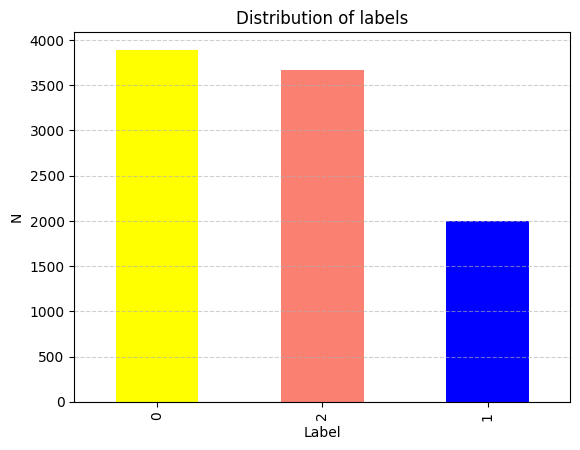

In [ ]:
# visualizing the difference between number of segments

df["label"].value_counts().plot(kind="bar", color = ["yellow","salmon","blue"])

plt.xlabel('Label')
plt.ylabel('N')
plt.title('Distribution of labels')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig("distribution_labels.png")
plt.show()

**AI-generated speeches:**

In [33]:
# loading dataset with ai-generated speeches
dataset = load_dataset("ibm-research/debate_speeches")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/948 [00:00<?, ? examples/s]

In [34]:
# giving overview over data
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['topic_id', 'topic', 'source', 'text', 'goodopeningspeech', 'mostargumentssupport', 'interestingspeaker', '#labelers', 'motion_set'],
        num_rows: 948
    })
})


In [35]:
# filtering ai-generated speeches and converting to dataframe
speech_ai_only = dataset["train"].filter(lambda x: x["source"] == "Speech-GPT2")

df_speech_ai = speech_ai_only.to_pandas()[["text"]]

print(df_speech_ai)

Filter:   0%|          | 0/948 [00:00<?, ? examples/s]

                                                  text
0    Assisted suicide should be a criminal offense....
1    We should abolish intelligence tests. Intellig...
2    We should ban cosmetic surgery. So, in this de...
3    We should end mandatory retirement. So, in thi...
4    We should legalize sex selection. So, in this ...
..                                                 ...
109  We should abandon tabloid journalism.  We thin...
110  We should protect Antarctica.  So, in this deb...
111  We should protect whistleblowers.  So, in the ...
112  We should subsidize Wikipedia.  So, in this de...
113  We should increase the use of scholarships.  I...

[114 rows x 1 columns]


In [36]:
# taking a sample of the ai-generated texts

df_speech_ai = df_speech_ai.sample(23, random_state=42, ignore_index=True)
print(len(df_speech_ai))
print(df_speech_ai)

23
                                                 text
0   We should ban genetically modified crops.  So,...
1   We should legalize sex selection. So, in this ...
2   We should further exploit sustainable energy. ...
3   We should abandon artificial intelligence.  So...
4   We should abandon social media, and we should ...
5   We should legalize organ trading, and we shoul...
6   We should abandon television.  So, in this deb...
7   We should ban surrogacy.  So, in this debate, ...
8   We should limit judicial review, and we should...
9   We should abandon speed limit enforcement.  So...
10  We should further exploit mixed-use developmen...
11  We should further exploit filibusters.  So we'...
12  We should ban racial profiling.  So, in this d...
13  We should subsidize Wikipedia.  So, in this de...
14  We should abolish the america's electoral coll...
15  Assisted suicide should be a criminal offense....
16  We should limit judicial activism.  So, in thi...
17  We should ban media c

In [37]:
# checking length of the texts for chunking
df_speech_ai['length'] = df_speech_ai['text'].apply(len)
average_length = df_speech_ai['length'].mean()
print(f"Average text length: {average_length:.2f} characters")

Average text length: 3339.17 characters


In [38]:
# making list with all the speeches for chunking it

list_ai = []

for element in df_speech_ai["text"]:
    list_ai.append(element)

In [39]:
list_ai_chunks = []
# Split the text into sentence-based chunks
for element in list_ai:
  sentence_chunks_ai = sentence_splitter.split_text(element)
  list_ai_chunks.append(sentence_chunks_ai)

print(list_ai_chunks)

[["We should ban genetically modified crops.  So, we think that in the future, genetic testing, for instance, which is very popular and often used to determine bloodlines, should be banned, because it has the effect of making people's genes, which are incredibly similar to someone else's genes, and putting them back into a sort of genetic algorithm that tries to make them as similar as possible", ".  We're okay with allowing people to get genetic testing for a limited purpose, like if they're planning on having a child, or if they're planning on having a child after a certain age, but we think that genetic testing should be banned.  We're okay with allowing people to get genetic testing for a limited purpose, but we think that genetic testing, in general, should be banned", ".  Our first argument is that this allows for racial discrimination.  Consider that, for instance, if you have a white, in the united states, and you want to select a gene that might be associated with white people

In [40]:
# appending the chunks with corresponding labels to the list

rows_ai = []

for chunks in list_ai_chunks:
  for chunk in chunks:
    rows_ai.append({"label": 2, "text": chunk})

In [41]:
# converting the list into the df with the necessary format for further processing

df_ai_chunks = pd.DataFrame(rows_ai, columns = ["label", "text"])
print(df_ai_chunks)

     label                                               text
0        2  We should ban genetically modified crops.  So,...
1        2  .  We're okay with allowing people to get gene...
2        2  .  Our first argument is that this allows for ...
3        2  .  So, ultimately, this is discriminatory, bec...
4        2  .  So, for instance, when people in the US use...
..     ...                                                ...
256      2  to be empowered, and in the status quo, we are...
257      2  .  So, if you're going to start a movement tha...
258      2  .  We think that women are empowered if they h...
259      2  if something, you know, harms someone in their...
260      2  .  And I think that this is why you need to st...

[261 rows x 2 columns]


#**Splitting the data and creating Dataset-Dictionary**

In [42]:
# splitting the dataset in train, evaluate and test data with seed=42, to ensure reproducability
train_df, test_dev_ds = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
dev_df, test_df = train_test_split(test_dev_ds, test_size=0.5, random_state=42, stratify=test_dev_ds["label"])

In [43]:
# combining ai-generated speeches and test_df
test_df_concatenated = pd.concat([test_df, df_ai_chunks], ignore_index=True)
print(test_df_concatenated)

      label                                               text
0         0  . Governor Tom Wolf announced the Plan for Pen...
1         0  . I think, though, to tell you that if—if I’m ...
2         2  . He joined in the nuclear test ban treaty. He...
3         0  . But they’re looking. They’re checking it out...
4         2  . Those forces will continue to have our sympa...
...     ...                                                ...
1212      2  to be empowered, and in the status quo, we are...
1213      2  .  So, if you're going to start a movement tha...
1214      2  .  We think that women are empowered if they h...
1215      2  if something, you know, harms someone in their...
1216      2  .  And I think that this is why you need to st...

[1217 rows x 2 columns]


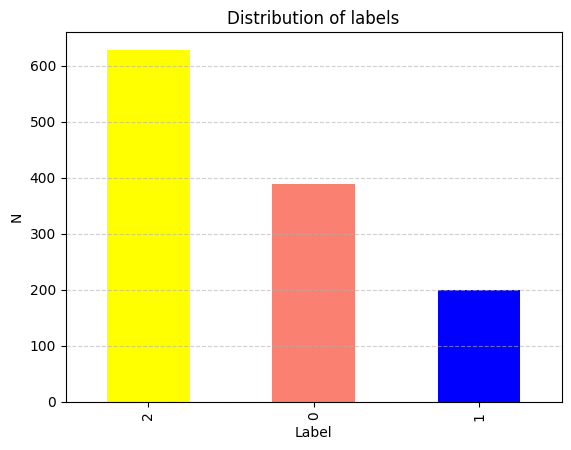

In [ ]:
# visualizing the difference between number of segments

test_df_concatenated["label"].value_counts().plot(kind="bar", color = ["yellow","salmon","blue"])

plt.xlabel('Label')
plt.ylabel('N')
plt.title('Distribution of labels')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig("distribution_labels_with_ai.png")
plt.show()

In [44]:
# converting each split in a dataset object

train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
dev_dataset = Dataset.from_pandas(dev_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df_concatenated, preserve_index=False)

In [45]:
# combining the dataset in to a DatasetDict for easier access (and as the standardized Huggingface format)

dataset_dict = DatasetDict({
    'train': train_dataset,
    'dev': dev_dataset,
    'test': test_dataset
})

#**Training ModernBERT**

In [ ]:
# the model we want to use as 'checkpoint'
checkpoint = "answerdotai/ModernBERT-base"
model = ModernBertForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [ ]:
# writing function for tokenization
def tokenize(data):
  return tokenizer(data['text'],truncation=True)

In [ ]:
# tokenizing the datasets
tokenized_datasets = dataset_dict.map(tokenize, batched=True)

Map:   0%|          | 0/7648 [00:00<?, ? examples/s]

Map:   0%|          | 0/956 [00:00<?, ? examples/s]

Map:   0%|          | 0/1217 [00:00<?, ? examples/s]

In [ ]:
# applying the padding to the data through the DataCollatorWithPadding Class for the Trainer
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

In [ ]:
# saving the dataset to Disk, so I can load it later
tokenized_datasets.save_to_disk('dataset_tokenized_modernbert')

Saving the dataset (0/1 shards):   0%|          | 0/7648 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/956 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1217 [00:00<?, ? examples/s]

In [ ]:
# creating function to compute and report metrics that are relevant for the NLP task
# f1, precision, recall and accuracy are typical for classification tasks
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average=None
    )
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "precision_label_0": precision[0],
        "recall_label_0": recall[0],
        "f1_label_0": f1[0],
        "precision_label_1": precision[1],
        "recall_label_1": recall[1],
        "f1_label_1": f1[1],
        "precision_label_2": precision[2],
        "recall_label_2": recall[2],
        "f1_label_2": f1[2],
    }

In [ ]:
# Setting up the Training Arguments
# evaluation_strategy="epoch" => report of the accuracy at the end of each epoch
model_name = f'{checkpoint}-finetuned'
logging_steps = len(tokenized_datasets['train'])
training_args = TrainingArguments(
    output_dir=model_name,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,   # learning rate, 1e-5 commonly used for finetuning
    num_train_epochs=2 , # number of epochs
    eval_strategy='epoch', # evaluation after each epoch
    weight_decay=0.01,
    logging_strategy='epoch',
    disable_tqdm=False,  # Show progress bar
    logging_steps=logging_steps, # number of update steps between the logs
    log_level='info', # shows basic infos while training
    report_to='none', # to train without wandb API
)

In [ ]:
# creating the Trainer with the model, training arguments, training and test dataset and the evaluation function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['dev'],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
# training the model
trainer.train()

The following columns in the Training set don't have a corresponding argument in `ModernBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `ModernBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 7,648
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 956
  Number of trainable parameters = 149,607,171
W0812 13:11:13.721000 347 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Accuracy,Precision Label 0,Recall Label 0,F1 Label 0,Precision Label 1,Recall Label 1,F1 Label 1,Precision Label 2,Recall Label 2,F1 Label 2
1,0.429400,0.257212,0.902720,0.867150,0.922879,0.894147,0.865922,0.775000,0.817942,0.961433,0.950954,0.956164
2,0.175100,0.220724,0.921548,0.919060,0.904884,0.911917,0.861538,0.840000,0.850633,0.955026,0.983651,0.969128


The following columns in the Evaluation set don't have a corresponding argument in `ModernBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `ModernBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 956
  Batch size = 16
Saving model checkpoint to model_name/checkpoint-500
Configuration saved in model_name/checkpoint-500/config.json
Model weights saved in model_name/checkpoint-500/model.safetensors
tokenizer config file saved in model_name/checkpoint-500/tokenizer_config.json
Special tokens file saved in model_name/checkpoint-500/special_tokens_map.json
Saving model checkpoint to model_name/checkpoint-956
Configuration saved in model_name/checkpoint-956/config.json
Model weights saved in model_name/checkpoint-956/model.safetensors
tokenizer config file saved in model_name/checkpoint-956/tokenizer_config.json
Special tokens file saved in model_name/checkpoint-956/speci

TrainOutput(global_step=956, training_loss=0.30220559251857104, metrics={'train_runtime': 488.2841, 'train_samples_per_second': 31.326, 'train_steps_per_second': 1.958, 'total_flos': 1034398910062656.0, 'train_loss': 0.30220559251857104, 'epoch': 2.0})

In [ ]:
# saving the model
trainer.save_model(model_name)

Saving model checkpoint to answerdotai/ModernBERT-base-finetuned
Configuration saved in answerdotai/ModernBERT-base-finetuned/config.json
Model weights saved in answerdotai/ModernBERT-base-finetuned/model.safetensors
tokenizer config file saved in answerdotai/ModernBERT-base-finetuned/tokenizer_config.json
Special tokens file saved in answerdotai/ModernBERT-base-finetuned/special_tokens_map.json


#**Evaluation ModernBERT**

In [ ]:
# testing the model with the test data
trainer.evaluate(eval_dataset=tokenized_datasets['test'])

The following columns in the Evaluation set don't have a corresponding argument in `ModernBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `ModernBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1217
  Batch size = 16


{'eval_loss': 0.5235602259635925,
 'eval_accuracy': 0.8447000821692687,
 'eval_precision_label_0': 0.7302904564315352,
 'eval_recall_label_0': 0.9048843187660668,
 'eval_f1_label_0': 0.8082663605051664,
 'eval_precision_label_1': 0.7939698492462312,
 'eval_recall_label_1': 0.79,
 'eval_f1_label_1': 0.7919799498746867,
 'eval_precision_label_2': 0.9664179104477612,
 'eval_recall_label_2': 0.8248407643312102,
 'eval_f1_label_2': 0.8900343642611683,
 'eval_runtime': 12.3541,
 'eval_samples_per_second': 98.51,
 'eval_steps_per_second': 6.233,
 'epoch': 2.0}

#**Models for comparison**

**Zero-shot-classification:**

In [ ]:
# loading zero-shot-classificator from huggingface
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

texts = test_df_concatenated["text"].to_list()

label_map = {
    0: "Trump speech",
    1: "Biden speech",
    2: "Other political speech"
}

true_labels_raw = test_df_concatenated["label"].to_list()
true_labels = [label_map[l] for l in true_labels_raw]

candidate_labels = list(label_map.values())

pred_labels = []
for t in texts:
    result = classifier(t, candidate_labels)
    pred_labels.append(result["labels"][0])

# calculating accuracy
acc = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {acc:.3f}")

# showing classification report
print(classification_report(true_labels, pred_labels))

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-mnli/snapshots/d7645e127eaf1aefc7862fd59a17a5aa8558b8ce/config.json
Model config BartConfig {
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForSequenceClassification"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "contradiction",
    "1": "neutral",
    "2": "entailment"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,

Accuracy: 0.532
                        precision    recall  f1-score   support

          Biden speech       0.17      0.01      0.01       200
Other political speech       0.53      0.99      0.69       628
          Trump speech       0.83      0.06      0.11       389

              accuracy                           0.53      1217
             macro avg       0.51      0.35      0.27      1217
          weighted avg       0.56      0.53      0.39      1217



**DistilBERT:**

In [ ]:
# the model we want to use as 'checkpoint'
second_checkpoint = "distilbert-base-uncased"
second_model = AutoModelForSequenceClassification.from_pretrained(second_checkpoint, num_labels=3)
second_tokenizer = AutoTokenizer.from_pretrained(second_checkpoint)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.55.0",
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e9

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.55.0",
  "vocab_size": 30522
}



vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer_config.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  

In [ ]:
# writing function for tokenization
def tokenize(data):
  return second_tokenizer(data['text'],truncation=True)

In [ ]:
# tokenizing the datasets
second_tokenized_datasets = dataset_dict.map(tokenize, batched=True)

Map:   0%|          | 0/7648 [00:00<?, ? examples/s]

Map:   0%|          | 0/956 [00:00<?, ? examples/s]

Map:   0%|          | 0/1217 [00:00<?, ? examples/s]

In [ ]:
# applying the padding to the data through the DataCollatorWithPadding Class for the Trainer
data_collator = DataCollatorWithPadding(tokenizer=second_tokenizer, return_tensors="pt")

In [ ]:
# saving the dataset to Disk, so I can load it later
second_tokenized_datasets.save_to_disk('dataset_tokenized_distilbert')

Saving the dataset (0/1 shards):   0%|          | 0/7648 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/956 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1217 [00:00<?, ? examples/s]

In [ ]:
# creating function to compute and report metrics that are relevant for the NLP task
# f1, precision, recall and accuracy are typical for classification tasks
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average=None
    )
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "precision_label_0": precision[0],
        "recall_label_0": recall[0],
        "f1_label_0": f1[0],
        "precision_label_1": precision[1],
        "recall_label_1": recall[1],
        "f1_label_1": f1[1],
        "precision_label_2": precision[2],
        "recall_label_2": recall[2],
        "f1_label_2": f1[2],
    }

In [ ]:
# Setting up the Training Arguments
# evaluation_strategy="epoch" => report of the accuracy at the end of each epoch
second_model_name = f'{second_checkpoint}-finetuned'
logging_steps = len(second_tokenized_datasets['train'])
second_training_args = TrainingArguments(
    output_dir=second_model_name,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,   # learning rate, 1e-5 commonly used for finetuning
    num_train_epochs=2 , # number of epochs
    eval_strategy='epoch', # evaluation after each epoch
    weight_decay=0.01,
    logging_strategy='epoch',
    disable_tqdm=False,  # Show progress bar
    logging_steps=logging_steps, # number of update steps between the logs
    log_level='info', # shows basic infos while training
    report_to='none', # to train without wandb API
)

PyTorch: setting up devices
average_tokens_across_devices is True but world size is 1. Setting it to False automatically.


In [ ]:
# creating the Trainer with the model, training arguments, training and test dataset and the evaluation function
trainer = Trainer(
    model=second_model,
    args=second_training_args,
    train_dataset=second_tokenized_datasets['train'],
    eval_dataset=second_tokenized_datasets['dev'],
    data_collator=data_collator,
    processing_class=second_tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
# training the model
trainer.train()

The following columns in the Training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 7,648
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 956
  Number of trainable parameters = 66,955,779


Epoch,Training Loss,Validation Loss,Accuracy,Precision Label 0,Recall Label 0,F1 Label 0,Precision Label 1,Recall Label 1,F1 Label 1,Precision Label 2,Recall Label 2,F1 Label 2
1,0.539500,0.352646,0.864017,0.861257,0.845758,0.853437,0.741117,0.730000,0.735516,0.931034,0.956403,0.943548
2,0.290800,0.298395,0.895397,0.863081,0.907455,0.884712,0.861272,0.745000,0.798928,0.946524,0.964578,0.955466


The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 956
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned/checkpoint-500/model.safetensors
tokenizer config file saved in distilbert-base-uncased-finetuned/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned/checkpoint-500/special_tokens_map.json
Saving model checkpoint to distilbert-base-uncased-finetuned/checkpoint-956
Configuration saved in distilbert-base-uncased-finetuned/checkpoint-956/config.json
Model weights saved in distilbert-base-uncase

TrainOutput(global_step=956, training_loss=0.41512881163273896, metrics={'train_runtime': 9893.5866, 'train_samples_per_second': 1.546, 'train_steps_per_second': 0.097, 'total_flos': 403552568239488.0, 'train_loss': 0.41512881163273896, 'epoch': 2.0})

In [ ]:
# saving the model
trainer.save_model(second_model_name)

Saving model checkpoint to distilbert-base-uncased-finetuned
Configuration saved in distilbert-base-uncased-finetuned/config.json
Model weights saved in distilbert-base-uncased-finetuned/model.safetensors
tokenizer config file saved in distilbert-base-uncased-finetuned/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned/special_tokens_map.json


In [ ]:
# testing the model with the test data
trainer.evaluate(eval_dataset=second_tokenized_datasets['test'])

The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1217
  Batch size = 16


{'eval_loss': 0.5858373045921326,
 'eval_accuracy': 0.7773212818405916,
 'eval_precision_label_0': 0.6219512195121951,
 'eval_recall_label_0': 0.9177377892030848,
 'eval_f1_label_0': 0.7414330218068536,
 'eval_precision_label_1': 0.8,
 'eval_recall_label_1': 0.66,
 'eval_f1_label_1': 0.7232876712328767,
 'eval_precision_label_2': 0.9560669456066946,
 'eval_recall_label_2': 0.7277070063694268,
 'eval_f1_label_2': 0.8264014466546112,
 'eval_runtime': 231.4658,
 'eval_samples_per_second': 5.258,
 'eval_steps_per_second': 0.333,
 'epoch': 2.0}

**BERT:**

In [46]:
# the model we want to use as 'checkpoint'
third_checkpoint = "bert-base-uncased"
third_model = AutoModelForSequenceClassification.from_pretrained(third_checkpoint, num_labels=3)
third_tokenizer = AutoTokenizer.from_pretrained(third_checkpoint)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [47]:
# writing function for tokenization
def tokenize(data):
  return third_tokenizer(data['text'],truncation=True)

In [48]:
# tokenizing the datasets
third_tokenized_datasets = dataset_dict.map(tokenize, batched=True)

Map:   0%|          | 0/7648 [00:00<?, ? examples/s]

Map:   0%|          | 0/956 [00:00<?, ? examples/s]

Map:   0%|          | 0/1217 [00:00<?, ? examples/s]

In [49]:
# applying the padding to the data through the DataCollatorWithPadding Class for the Trainer
data_collator = DataCollatorWithPadding(tokenizer=third_tokenizer, return_tensors="pt")

In [50]:
# saving the dataset to Disk, so I can load it later
third_tokenized_datasets.save_to_disk('dataset_tokenized_bert')

Saving the dataset (0/1 shards):   0%|          | 0/7648 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/956 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1217 [00:00<?, ? examples/s]

In [51]:
# creating function to compute and report metrics that are relevant for the NLP task
# f1, precision, recall and accuracy are typical for classification tasks
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average=None
    )
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "precision_label_0": precision[0],
        "recall_label_0": recall[0],
        "f1_label_0": f1[0],
        "precision_label_1": precision[1],
        "recall_label_1": recall[1],
        "f1_label_1": f1[1],
        "precision_label_2": precision[2],
        "recall_label_2": recall[2],
        "f1_label_2": f1[2],
    }

In [52]:
# Setting up the Training Arguments
# evaluation_strategy="epoch" => report of the accuracy at the end of each epoch
third_model_name = f'{third_checkpoint}-finetuned'
logging_steps = len(third_tokenized_datasets['train'])
third_training_args = TrainingArguments(
    output_dir=third_model_name,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,   # learning rate, 1e-5 commonly used for finetuning
    num_train_epochs=2 , # number of epochs
    eval_strategy='epoch', # evaluation after each epoch
    weight_decay=0.01,
    logging_strategy='epoch',
    disable_tqdm=False,  # Show progress bar
    logging_steps=logging_steps, # number of update steps between the logs
    log_level='info', # shows basic infos while training
    report_to='none', # to train without wandb API
)

In [53]:
# creating the Trainer with the model, training arguments, training and test dataset and the evaluation function
trainer = Trainer(
    model=third_model,
    args=third_training_args,
    train_dataset=third_tokenized_datasets['train'],
    eval_dataset=third_tokenized_datasets['dev'],
    data_collator=data_collator,
    processing_class=third_tokenizer,
    compute_metrics=compute_metrics,
)

In [54]:
# training the model
trainer.train()

The following columns in the Training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 7,648
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 956
  Number of trainable parameters = 109,484,547


Epoch,Training Loss,Validation Loss,Accuracy,Precision Label 0,Recall Label 0,F1 Label 0,Precision Label 1,Recall Label 1,F1 Label 1,Precision Label 2,Recall Label 2,F1 Label 2
1,0.480400,0.275245,0.896444,0.840647,0.935733,0.885645,0.890909,0.735000,0.805479,0.966480,0.942779,0.954483
2,0.219700,0.247366,0.916318,0.866511,0.951157,0.906863,0.927273,0.765000,0.838356,0.969780,0.961853,0.965800


The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 956
  Batch size = 16
Saving model checkpoint to bert-base-uncased-finetuned/checkpoint-500
Configuration saved in bert-base-uncased-finetuned/checkpoint-500/config.json
Model weights saved in bert-base-uncased-finetuned/checkpoint-500/model.safetensors
tokenizer config file saved in bert-base-uncased-finetuned/checkpoint-500/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned/checkpoint-500/special_tokens_map.json
Saving model checkpoint to bert-base-uncased-finetuned/checkpoint-956
Configuration saved in bert-base-uncased-finetuned/checkpoint-956/config.json
Model weights saved in bert-base-uncased-finetuned/checkpoint-956/model.safetensors
tokenizer confi

TrainOutput(global_step=956, training_loss=0.35006780105654667, metrics={'train_runtime': 389.2175, 'train_samples_per_second': 39.299, 'train_steps_per_second': 2.456, 'total_flos': 801542137931136.0, 'train_loss': 0.35006780105654667, 'epoch': 2.0})

In [55]:
# saving the model
trainer.save_model(third_model_name)

Saving model checkpoint to bert-base-uncased-finetuned
Configuration saved in bert-base-uncased-finetuned/config.json
Model weights saved in bert-base-uncased-finetuned/model.safetensors
tokenizer config file saved in bert-base-uncased-finetuned/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned/special_tokens_map.json


In [56]:
# testing the model with the test data
trainer.evaluate(eval_dataset=third_tokenized_datasets['test'])

The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1217
  Batch size = 16


{'eval_loss': 0.6484749913215637,
 'eval_accuracy': 0.7756778964667215,
 'eval_precision_label_0': 0.6025437201907791,
 'eval_recall_label_0': 0.974293059125964,
 'eval_f1_label_0': 0.7445972495088409,
 'eval_precision_label_1': 0.9060402684563759,
 'eval_recall_label_1': 0.675,
 'eval_f1_label_1': 0.7736389684813754,
 'eval_precision_label_2': 0.979498861047836,
 'eval_recall_label_2': 0.6847133757961783,
 'eval_f1_label_2': 0.8059981255857545,
 'eval_runtime': 6.5576,
 'eval_samples_per_second': 185.587,
 'eval_steps_per_second': 11.742,
 'epoch': 2.0}